## Regression Returns

Description:     
In this approach, we treat the next-bar (or multi-bar) return as a continuous variable and use a regression model (e.g., RandomForestRegressor) to predict it. Positive predicted returns imply a potential buy signal, negative imply a sell, and near-zero might mean no trade. This method captures magnitude of price movement rather than just direction.

#### 📌 Important Note:
This notebook contains *interactive charts generated using Vectorbt.  
GitHub does not display interactive Plotly charts, so the graphs will not be visible here.  

✅ To view the charts, please download this notebook and run it on your local machine.  
Make sure you have Vectorbt and its dependencies installed to regenerate the visualizations.


## Part 1: Data & Feature Engineering

**Objective:**  
Load raw price data (MetaTrader 5 or CSV) and transform it into a feature-rich dataset.

**Tasks:**
- Fetch historical bars  
- Apply `ta.add_all_ta_features` or custom features  
- (Optionally) create specific labels (multi-bar, double-barrier, regime, etc.)  
- Clean/prepare the final feature matrix **X** and target **y**  

In [ ]:
import sys
import os
import warnings
from pathlib import Path

# ---------------------------------------------------------------------------
# 1) SET PROJECT ROOT AND UPDATE PATH/WORKING DIRECTORY
# ---------------------------------------------------------------------------
project_root = Path.cwd().parent.parent  # Adjust if your notebook is in notebooks/time_series
sys.path.append(str(project_root))
os.chdir(str(project_root))
warnings.filterwarnings("ignore")

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import MetaTrader5 as mt5
import vectorbt as vbt


# Our modules
from data.data_loader import get_data_mt5
from features.feature_engineering import add_all_ta_features
from models.model_training import (
    select_features_rf_reg,
    walk_forward_splits
)
# Updated simulate_trading that handles cost
from backtests.simple_backtest import simulate_trading, calculate_sharpe_ratio

from features.labeling_schemes import calculate_future_returns

# Sklearn / Models
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import BayesianRidge



###########################################################
# 1) DATA LOADING & FEATURE ENGINEERING
###########################################################
if not mt5.initialize():
    print("Failed to initialize MT5")
else:
    # Fetch 2000 bars from an earlier period for training
    data = get_data_mt5(symbol="BTCUSD", timeframe=mt5.TIMEFRAME_H4, n_bars=2000, start_pos=2000)

    mt5.shutdown()

df = add_all_ta_features(data)
df = calculate_future_returns(df).dropna(subset=["future_returns"])

# Prepare X, y
X = df.drop(columns=["future_returns"])
y = df["future_returns"]

###########################################################
# 2) WALK-FORWARD SPLITS
###########################################################
folds = walk_forward_splits(X, y, n_splits=3)
print(f"Number of folds created: {len(folds)}")

###########################################################
# 3) DEFINE MODELS
###########################################################
models = { 
    "GradientBoostingRegressor": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    "RandomForestRegressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "LinearRegression": LinearRegression(),
    "SVR": SVR(C=1.0, epsilon=0.2),
    "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=5),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "DecisionTreeRegressor": DecisionTreeRegressor(max_depth=5),
    "XGBRegressor": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "LGBMRegressor": LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "BayesianRidge": BayesianRidge()  # <-- Added Probabilistic Model
}

###########################################################
# 4) LOOP OVER FOLDS + SIMPLE BACKTEST (with threshold & cost)
###########################################################
from sklearn.metrics import mean_squared_error

fold_results = {}
threshold = 0.0005  # Only trade if predicted next-bar return > +0.0005 or < -0.0005
cost = 0.0002       # 0.02% transaction cost each position change

for fold_i, (X_train_fold, y_train_fold, X_test_fold, y_test_fold) in enumerate(folds, start=1):
    print(f"\n===== Fold {fold_i} =====")

    # Feature selection
    rf_for_fs = RandomForestRegressor(n_estimators=100, random_state=42)
    X_train_sel, selected_idx = select_features_rf_reg(
        X_train_fold, y_train_fold, estimator=rf_for_fs, max_features=20
    )

    # Convert integer positions to actual column names
    feats = X_train_fold.columns[selected_idx]
    print(f"Selected features for Fold {fold_i}: {feats.tolist()}")

    X_test_sel = X_test_fold[feats]

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_sel)
    X_test_scaled = scaler.transform(X_test_sel)

    # We'll store MSE and backtest results for each model
    fold_results[fold_i] = {}

    for model_name, model in models.items():
        # 4.1 Train
        model.fit(X_train_scaled, y_train_fold)
        preds = model.predict(X_test_scaled)

        # 4.2 Evaluate MSE
        mse = mean_squared_error(y_test_fold, preds)

        # 4.3 Convert predictions => signals with threshold
        signals = np.where(preds > threshold, 1, np.where(preds < -threshold, -1, 0))

        # 4.4 Align the test portion of df with the same indices
        df_test_fold = df.loc[X_test_fold.index].copy()

        # 4.5 Run the simple backtest with cost
        daily_returns, total_return = simulate_trading(signals, df_test_fold, cost=cost)
        sr = calculate_sharpe_ratio(np.array(daily_returns))

        fold_results[fold_i][model_name] = {
            "MSE": mse,
            "TotalReturn": total_return,
            "Sharpe": sr
        }

    # End of model loop

# End of fold loop

###########################################################
# 5) PRINT RESULTS - Ranking Based on Sharpe, Returns & MSE
###########################################################

# Store best models for each fold
best_models = {}

for fold_i, model_dict in fold_results.items():
    print(f"\n=== Fold {fold_i} Results ===")
    
    # Convert results to a DataFrame for easier ranking
    results_df = pd.DataFrame(model_dict).T  # Transpose to have models as rows
    results_df = results_df.sort_values(by=["Sharpe", "TotalReturn"], ascending=False)  # Rank models

    print(results_df)

    # Select the best model per fold (highest Sharpe Ratio)
    best_model = results_df.index[0]
    best_models[fold_i] = best_model

    print(f"\n🏆 Best Model for Fold {fold_i}: {best_model}\n")

# Print best models for each fold
print("\nBest Models Across Folds:", best_models)




Number of folds created: 3

===== Fold 1 =====
Selected features for Fold 1: ['volume_obv', 'trend_kst_diff', 'momentum_pvo_hist', 'momentum_tsi', 'trend_dpo', 'tick_volume', 'trend_mass_index', 'volume_adi', 'volume_cmf', 'volume_nvi', 'volatility_dcw', 'volume_em', 'momentum_stoch_signal', 'momentum_roc', 'volume_mfi', 'volatility_bbw', 'trend_adx_pos', 'volatility_bbm', 'momentum_rsi', 'others_dlr']


  File "c:\Users\moham\miniconda3\envs\ml\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\moham\miniconda3\envs\ml\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\moham\miniconda3\envs\ml\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\moham\miniconda3\envs\ml\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1647
[LightGBM] [Info] Number of data points in the train set: 249, number of used features: 20
[LightGBM] [Info] Start training from score 0.000680
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

## Part 2: Model Training & Hyperparameter Tuning

**Objective:**  
Train an ML model (e.g., RandomForest, XGBoost) on the engineered features to predict the chosen labels.

**Tasks:**
- Perform time-based or walk-forward splits  
- Select top features if desired (e.g., using RandomForest feature importance)  
- Use `RandomizedSearchCV` or `GridSearchCV` to find optimal hyperparameters  
- Save the best model pipeline (e.g., `best_rf_pipeline.pkl`) 

 Hyperparameter Tuning with RandomizedSearchCV

In [ ]:
# Code 2: Hyperparameter Tuning for Chosen Model

import sys
import os
import warnings
from pathlib import Path

# ---------------------------------------------------------------------------
# 1) SET PROJECT ROOT AND UPDATE PATH/WORKING DIRECTORY
# ---------------------------------------------------------------------------
project_root = Path.cwd().parent.parent  # Adjust if your notebook is in notebooks/time_series
sys.path.append(str(project_root))
os.chdir(str(project_root))
warnings.filterwarnings("ignore")

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import MetaTrader5 as mt5
import joblib

# Sklearn / Models
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

# Optional: If you want a pipeline
from sklearn.pipeline import Pipeline

# Your modules
from data.data_loader import get_data_mt5
from features.feature_engineering import add_all_ta_features
from features.labeling_schemes import calculate_future_returns

###########################################################
# 1) DATA LOADING & FEATURE ENGINEERING
###########################################################
# In Code 1, you discovered that RandomForestRegressor generally outperforms.
# Now we do a narrower hyperparam tuning on the older portion of the data.

if not mt5.initialize():
    print("Failed to initialize MT5")
else:
    # Fetch 2000 bars from an earlier period for training
    data = get_data_mt5(symbol="BTCUSD", timeframe=mt5.TIMEFRAME_H4, n_bars=2000, start_pos=2000)

    mt5.shutdown()

df = add_all_ta_features(data)
df = calculate_future_returns(df).dropna(subset=["future_returns"])

X_full = df.drop(columns=["future_returns"])
y_full = df["future_returns"]

# Sort df if needed to ensure chronological order
# df = df.sort_index()  # or df = df.sort_values('time') if you have that column
# Then X_full and y_full should match that order

###########################################################
# 2) DEFINE YOUR TRAIN PORTION
###########################################################
# For example, let's use the first 80% for hyperparam tuning
split_idx = int(len(X_full)*0.8)
X_tune = X_full.iloc[:split_idx].copy()
y_tune = y_full.iloc[:split_idx].copy()

print(f"Tuning portion size: {len(X_tune)}")

###########################################################
# 3) TIME-BASED CV (TimeSeriesSplit)
###########################################################
tscv = TimeSeriesSplit(n_splits=3)

# We'll define a negative MSE scorer, because scikit-learn tries to maximize the score
def neg_mse_scorer(estimator, X, y):
    preds = estimator.predict(X)
    return -mean_squared_error(y, preds)

scorer = make_scorer(mean_squared_error, greater_is_better=False)

###########################################################
# 4) BUILD A PIPELINE (optional) OR JUST USE RF
###########################################################
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(random_state=42))
])

###########################################################
# 5) DEFINE PARAM DISTRIBUTIONS FOR RandomForest
###########################################################
param_distributions = {
    "rf__n_estimators": [100, 200, 300],
    "rf__max_depth": [None, 5, 10, 15],
    "rf__min_samples_split": [2, 5, 10],
    "rf__max_features": ["auto", "sqrt", 0.5]
}

###########################################################
# 6) SET UP RandomizedSearchCV
###########################################################
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=10,             # how many random combos
    scoring=neg_mse_scorer,  # or you can use 'neg_mean_squared_error'
    cv=tscv,               # time-based folds
    random_state=42,
    n_jobs=-1,
    verbose=2
)

###########################################################
# 7) FIT ON TUNING PORTION
###########################################################
random_search.fit(X_tune, y_tune)

print("Best params:", random_search.best_params_)
print("Best neg MSE:", random_search.best_score_)

best_estimator = random_search.best_estimator_

###########################################################
# 8) SAVE THE BEST ESTIMATOR
###########################################################
joblib.dump(best_estimator, "models/saved_models/best_rf_pipeline.pkl")
print("Saved best estimator to 'best_rf_pipeline.pkl'")


Tuning portion size: 1599
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'rf__n_estimators': 100, 'rf__min_samples_split': 2, 'rf__max_features': 0.5, 'rf__max_depth': 5}
Best neg MSE: -0.0001469375124074844
Saved best estimator to 'best_rf_pipeline.pkl'


 Hyperparameter Tuning with Optuna

Tuning portion size: 1599


[I 2025-02-26 23:11:42,530] A new study created in memory with name: no-name-6d2ef82f-7dc4-4111-9fc5-7afef1c1e671


Selected Top Features: ['tick_volume', 'trend_dpo', 'volume_fi', 'trend_adx', 'volume_em', 'momentum_roc', 'trend_kst_diff', 'volume_cmf', 'volume_mfi', 'trend_adx_neg', 'trend_vortex_ind_pos', 'high', 'momentum_ppo_hist', 'momentum_pvo_hist', 'volume_adi', 'volume_nvi', 'volume_vpt', 'momentum_uo', 'volume_obv', 'trend_adx_pos']


[I 2025-02-26 23:11:44,048] Trial 0 finished with value: 0.0001386007128899321 and parameters: {'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 19, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.0001386007128899321.
[I 2025-02-26 23:12:01,537] Trial 1 finished with value: 0.00015018142535211192 and parameters: {'n_estimators': 300, 'max_depth': 19, 'min_samples_split': 13, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.0001386007128899321.
[I 2025-02-26 23:13:37,167] Trial 2 finished with value: 0.000292214430164521 and parameters: {'n_estimators': 700, 'max_depth': 26, 'min_samples_split': 17, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.0001386007128899321.
[I 2025-02-26 23:13:53,424] Trial 3 finished with value: 0.00013959751234432274 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_samples_split': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.0001386


Best Trial: FrozenTrial(number=15, state=1, values=[0.00012874181105968922], datetime_start=datetime.datetime(2025, 2, 26, 23, 17, 33, 763117), datetime_complete=datetime.datetime(2025, 2, 26, 23, 17, 47, 281903), params={'n_estimators': 800, 'max_depth': 5, 'min_samples_split': 9, 'max_features': 'log2', 'bootstrap': True}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=100), 'max_depth': IntDistribution(high=30, log=False, low=5, step=1), 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2', 0.5, 0.8, None)), 'bootstrap': CategoricalDistribution(choices=(True, False))}, trial_id=15, value=None)
Saved best model to 'models/saved_models/best_rf_pipeline.pkl'


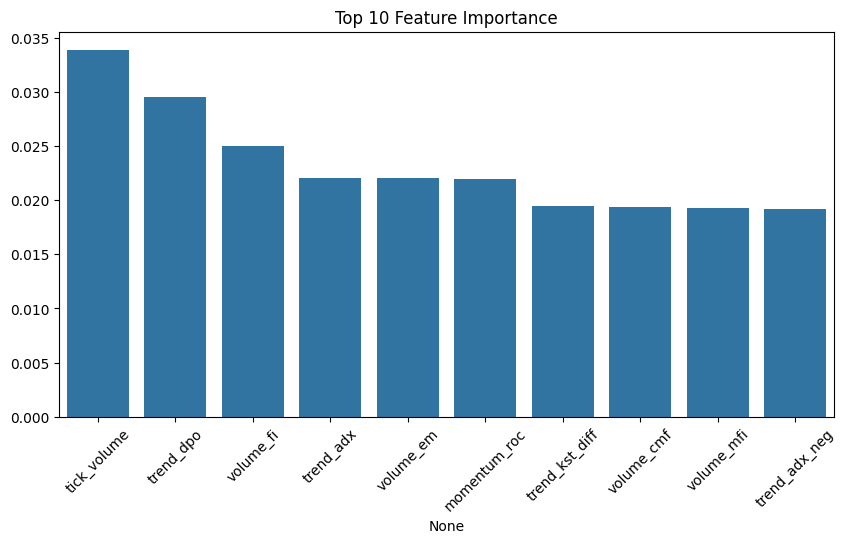

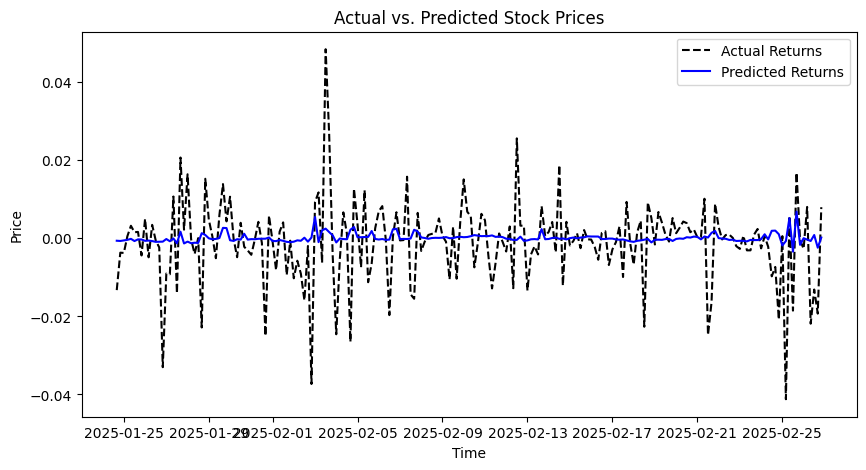

In [ ]:
import sys
import os
import warnings
from pathlib import Path

# ---------------------------------------------------------------------------
# 1) SET PROJECT ROOT AND UPDATE PATH/WORKING DIRECTORY
# ---------------------------------------------------------------------------
project_root = Path.cwd().parent.parent  # Adjust if your notebook is in notebooks/time_series
sys.path.append(str(project_root))
os.chdir(str(project_root))
warnings.filterwarnings("ignore")

import os
from pathlib import Path
import warnings
import pandas as pd
import numpy as np
import MetaTrader5 as mt5
import joblib
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn / Models
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

# Optuna visualization
import optuna.visualization as ov

# Your modules
from data.data_loader import get_data_mt5
from features.feature_engineering import add_all_ta_features
from features.labeling_schemes import calculate_future_returns

warnings.filterwarnings("ignore")

###########################################################
# 1) DATA LOADING & FEATURE ENGINEERING
###########################################################
if not mt5.initialize():
    print("Failed to initialize MT5")
else:
    # Fetch 2000 bars from an earlier period for training
    data = get_data_mt5(symbol="BTCUSD", timeframe=mt5.TIMEFRAME_H4, n_bars=2000, start_pos=2000)

    mt5.shutdown()

df = add_all_ta_features(data)
df = calculate_future_returns(df).dropna(subset=["future_returns"])

X_full = df.drop(columns=["future_returns"])
y_full = df["future_returns"]

# Sort to maintain chronological order
# df = df.sort_values("time") if 'time' in df.columns else df.sort_index()

###########################################################
# 2) DEFINE TRAIN PORTION
###########################################################
split_idx = int(len(X_full) * 0.8)
X_tune, y_tune = X_full.iloc[:split_idx], y_full.iloc[:split_idx]

print(f"Tuning portion size: {len(X_tune)}")

###########################################################
# 3) FEATURE SELECTION
###########################################################
rf_for_fs = RandomForestRegressor(n_estimators=100, random_state=42)
rf_for_fs.fit(X_tune, y_tune)

feature_importance = pd.Series(rf_for_fs.feature_importances_, index=X_tune.columns)
top_features = feature_importance.nlargest(20).index
X_tune = X_tune[top_features]

print(f"Selected Top Features: {list(top_features)}")

###########################################################
# 4) TIME-SERIES CROSS VALIDATION
###########################################################
tscv = TimeSeriesSplit(n_splits=3)

def objective(trial):
    """Objective function for Optuna"""
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.5, 0.8, None]),  # Fixed
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False])
    }

    model = Pipeline([
        ("scaler", StandardScaler()),
        ("rf", RandomForestRegressor(**params, random_state=42))
    ])

    scores = []
    for train_idx, test_idx in tscv.split(X_tune):
        X_train_fold, X_test_fold = X_tune.iloc[train_idx], X_tune.iloc[test_idx]
        y_train_fold, y_test_fold = y_tune.iloc[train_idx], y_tune.iloc[test_idx]

        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_test_fold)
        scores.append(mean_squared_error(y_test_fold, preds))

    return np.mean(scores)



###########################################################
# 5) RUN OPTUNA OPTIMIZATION
###########################################################
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, timeout=1800)  # 50 trials or 30 min max

print("\nBest Trial:", study.best_trial)

###########################################################
# 6) RETRAIN BEST MODEL
###########################################################
best_params = study.best_params

best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(**best_params, random_state=42))
])

best_model.fit(X_tune, y_tune)

###########################################################
# 7) SAVE BEST MODEL
###########################################################
joblib.dump(best_model, "models/saved_models/best_rf_pipeline.pkl")
print("Saved best model to 'models/saved_models/best_rf_pipeline.pkl'")

###########################################################
# 8) PLOTTING RESULTS
###########################################################

# 📊 Plot 1: Optimization History (Loss over Trials)
ov.plot_optimization_history(study).show()

# 📊 Plot 2: Parameter Importance
ov.plot_param_importances(study).show()

# 📊 Plot 3: Parallel Coordinate Plot (Best Hyperparameters)
ov.plot_parallel_coordinate(study).show()

# 📊 Plot 4: Feature Importance of Selected Features
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance.nlargest(10).index, y=feature_importance.nlargest(10).values)
plt.xticks(rotation=45)
plt.title("Top 10 Feature Importance")
plt.show()

# 📊 Plot 5: Actual vs Predicted Returns on Test Set
split_idx_test = int(len(X_full) * 0.9)  # Use last 10% for final testing
X_test, y_test = X_full.iloc[split_idx_test:], y_full.iloc[split_idx_test:]

# Apply the same feature selection as during training
X_test = X_test[top_features]  # Ensure features match the trained model

# Make predictions
y_pred = best_model.predict(X_test)

# Plot actual vs predicted returns
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual Returns", color="black", linestyle="dashed")
plt.plot(y_test.index, y_pred, label="Predicted Returns", color="blue")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.show()



## Part 3: Backtesting & Performance Evaluation

**Objective:**  
Evaluate how well the trained model performs on unseen data, simulating real trades.

**Tasks:**
- Use walk-forward or expanding splits to mimic “live” conditions  
- Convert model predictions to signals ([-1, 0, +1] or buy/sell/hold)  
- Run a simple backtest script or VectorBT for performance metrics  
- Calculate returns, Sharpe ratio, drawdowns, confusion matrix, etc.  
- Visualize results (equity curve, trades, etc.) to judge strategy viability  

In [ ]:
import sys
import os
import warnings
from pathlib import Path

# ---------------------------------------------------------------------------
# 1) SET PROJECT ROOT AND UPDATE PATH/WORKING DIRECTORY
# ---------------------------------------------------------------------------
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))
os.chdir(str(project_root))
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import MetaTrader5 as mt5
import vectorbt as vbt
import joblib

# Our modules
from data.data_loader import get_data_mt5
from features.feature_engineering import add_all_ta_features
from features.labeling_schemes import calculate_future_returns

# Sklearn
from sklearn.metrics import mean_squared_error

###########################################################
# 1) DATA LOADING & FEATURE ENGINEERING
###########################################################
if not mt5.initialize():
    print("Failed to initialize MT5")
else:
    # Fetch 2000 most recent bars for backtesting
    data = get_data_mt5(symbol="BTCUSD", timeframe=mt5.TIMEFRAME_H4, n_bars=2000, start_pos=0)
    mt5.shutdown()

df = add_all_ta_features(data)
df = calculate_future_returns(df).dropna(subset=["future_returns"])

# Ensure chronological order if needed
df = df.sort_index()

# Separate features and target
X = df.drop(columns=["future_returns"])
y = df["future_returns"]

###########################################################
# 2) LOAD PRE-TRAINED PIPELINE (NO RETRAINING)
###########################################################
best_pipeline = joblib.load("models/saved_models/best_rf_pipeline.pkl")
print("Loaded best pipeline from 'best_rf_pipeline.pkl'")

# 1) Identify the columns used during training
trained_columns = best_pipeline["scaler"].feature_names_in_

# 2) Subset X to match the columns the pipeline was trained on
X_test = X[trained_columns]

# 3) Predict on the new dataset (pipeline handles scaling + model)
preds = best_pipeline.predict(X_test)

# Align target to prediction index for a fair MSE
y_test = y.loc[X_test.index]
mse = mean_squared_error(y_test, preds)

###########################################################
# 3) BACKTEST via target exposure (-1, 0, +1)  << UPDATED
###########################################################
threshold = 0.0005  # Min predicted return magnitude to take a position

# Map regression predictions -> exposure {-1, 0, +1}
exposure = np.where(preds > threshold, 1.0,
            np.where(preds < -threshold, -1.0, 0.0)).astype(float)

# Align prices exactly to prediction rows (no padding)
close = df.loc[X_test.index, "close"]

# Optional: trade on next bar to avoid look-ahead (set to 0 for same-bar)
execution_lag = 1
exposure = pd.Series(exposure, index=close.index)
if execution_lag > 0:
    exposure = exposure.shift(execution_lag).fillna(0.0)

fees = 0.0002  # 0.02% transaction cost per trade

pf = vbt.Portfolio.from_orders(
    close=close,
    size=exposure,              # -1 short, 0 flat, +1 long
    size_type='targetpercent',
    init_cash=10000,
    freq='4H',
    fees=fees
)

total_return = pf.total_return()
sharpe_ratio = pf.sharpe_ratio()

print("\nFull Backtest Results:")
print(f"MSE={mse:.2e}, Return={total_return:.2f}%, Sharpe={sharpe_ratio:.2f}")
print(pf.stats())

# Optional: Plot the backtest results
fig = pf.plot()
fig.show()


Loaded best pipeline from 'best_rf_pipeline.pkl'

Running Full Backtest on the Last 2000 Bars...

Full Backtest Results:
MSE=1.11e-04, Return=5.85%, Sharpe=5.71
Start                               2024-04-03 12:00:00
End                                 2025-03-02 12:00:00
Period                                333 days 04:00:00
Start Value                                     10000.0
End Value                                  68507.285233
Total Return [%]                             585.072852
Benchmark Return [%]                          29.937741
Max Gross Exposure [%]                            100.0
Total Fees Paid                              916.100044
Max Drawdown [%]                              11.312433
Max Drawdown Duration                  68 days 12:00:00
Total Trades                                         59
Total Closed Trades                                  58
Total Open Trades                                     1
Open Trade PnL                              3366.131812